## A Step-by-step Implementation of a Trading Strategy in Python using ARIMA + GARCH models
* **Link:** https://medium.com/analytics-vidhya/a-step-by-step-implementation-of-a-trading-strategy-in-python-using-arima-garch-models-b622e5b3aa39 
* **Implementation Method:** Python implementation of ARIMA + Garch which is the improvement on Arima And Garch applied in R
* **Data:** S&P Index from 1950-December 2020
* **Summary:** Uses Arima model to fit the log of the closing statement each day and then uses GARCH to fit the residuals from ARIMA. Takes the sum of those to then compare against cumulative gains which is calculative through a cumulative sum of the log of closing values. 

In R and Python, Arima model was fit by looping through several hyper-parameters and choosing lowest AIC. Through the Arima and Garch forecasts, signals are created. Our strategy will simply long the position if the prediction is 1 (up) and short if the prediction is -1 (down) 

* The goal of this strategy is to compare it to a basic buy and hold strategy with a particular stock and to also compare to a startegy implemented in R that uses a combinayion of ARIMA and GARCH model to come up with a prediction. 
* This strategy also uses ARIMA + GARCH models to get the predictions but the models are fitted differently. 
* Signals from the baseline model are stored in the sp500_forecasts file. 

First, they test the baseline startegy of ARIMA + GARCH implementation in R against a simple buy and hold strategy

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf

First step is to load the signal given by the baseline startegy. So we use read_csv to read the file and give each signal value a date as an index

In [4]:
forecasts = pd.read_csv('/users/shreyawalia/desktop/sp500_forecasts_new.csv', header=None).rename(columns={0: 'Date', 1: 'Signal'})
forecasts.set_index('Date', inplace=True)
forecasts.index = pd.to_datetime(forecasts.index)

Here you can see that the forecasts is just the signal representing a value of 1 or -1.

In [5]:
forecasts.head()

,Signal
Date,
1952-01-03,1
1952-01-04,1
1952-01-07,1
1952-01-08,1
1952-01-09,1


Next to compare to a basic buy and hold startegy, we load the sp500 data using the yfinance library. 

In [6]:
df= yf.Ticker('^GSPC').history(period='max')
df = df[(df.index > '1952-01-03') & (df.index < '2020-12-30')]

Next, we add the strategy signal to the dataframe of the data pulled using yfinance. Looking at the dataframe, we can see that it includes, open, high, low, close, volume, dividens and stock splits for each stock including the predicted signal.  

In [7]:
df['Signal'] = forecasts['Signal']
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Signal
Date,,,,,,,,
1952-01-04,23.92,23.92,23.92,23.92,1480000,0,0,1
1952-01-07,23.91,23.91,23.91,23.91,1540000,0,0,1
1952-01-08,23.82,23.82,23.82,23.82,1390000,0,0,1
1952-01-09,23.74,23.74,23.74,23.74,1370000,0,0,1
1952-01-10,23.86,23.86,23.86,23.86,1520000,0,0,-1


Finally, to calculate the total returns from the buy and hold strategy, we first calculate the lof of returns from closing value of the stock.

Next, for caculating the strategy log returns, we take the log of the closing value and multiple that by our signal of 1 or -1. 

In [8]:
df['LogRets'] = np.log(df['Close'] / df['Close'].shift(1))
df['StratLogRets'] = df['LogRets'] * df['Signal']

Then, to calculate cummulative returns, we use the cumsum() function.

In [9]:
df['BuyHold_Log_Returns'] = df['LogRets'].cumsum()
df['Strategy_Log_Returns'] = df['StratLogRets'].cumsum()

The final step is to get our returns back in absolute value using exponential function and then plotting the returns of each strategy on the same plot.

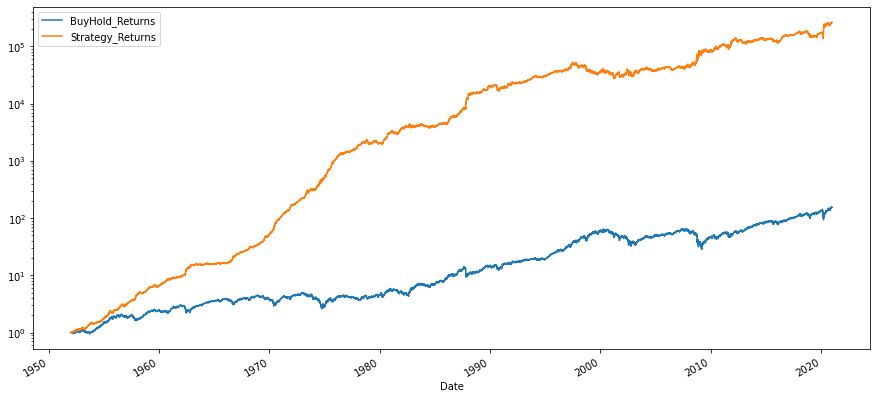

In [10]:
df['BuyHold_Returns'] = np.exp(df['BuyHold_Log_Returns'])
df['Strategy_Returns'] = np.exp(df['Strategy_Log_Returns'])


_ = df[['BuyHold_Returns', 'Strategy_Returns']].plot(figsize=(15, 7), logy=True)

To grab the data from 2000 to 2020 and create the returns, the author of the case study created a class called Stock to automate the process of getting returns calculated based on starting and stopping index. Using this class, you can also compare any strategies as long as you have the predicted signal from them. 

In [11]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt


class Stock:
    # the init function takes in the input stock and creates a ticker for it using the yfinance library and then pulls all available data on it, if no start or end is mentioned.
    # However, if the start and end dates are input then thats the period of data it calls.
    def __init__(self, ticker, start=None, end=None):
        self.ticker = ticker

        try:
            self._ticker = yf.Ticker(self.ticker)

            if not (start or end):
                self.df = self.df_ = self._ticker.history(period='max')

            else:
                self.df = self.df_ = self._ticker.history(start=start, end=end)

        except Exception as err:
            print(err)
    
    #This function takes in the stock name and a start and end date.
    # The purpose of this function is to provide the user an oppurtunity to change the date range where they observe the stock price
    # In the event that all the stock data is pulled up to current data, this function will allow the user 
    # to access any given date range without downloading the data from Yfinance everytime the period of interest changes.
    def change_date_range(self, start=None, end=None):
        """Change the start and end dates of the visible dataframe. The property df_ is kept under the
        hoods to avoid reloading from yahoo all the time"""
        start = self.start_date if start is None else start
        end = self.end_date if end is None else end

        self.df = self.df_[(self.df_.index >= start) & (self.df_.index <= end)]
    
    # This function takes in the input of the stock and index(date range)
    # when the date index does not exist, it outputs an index of dates up till the current date. 
    def get_value_by_index(self, index, column):
        """When the date index does not exist, get the following date"""
        index = pd.to_datetime(index)
        if index in self.df.index:
            return self.df.loc[index, column]
        else:
            return self.df.loc[self.df.index > index].iloc[0][column]
    
    #This function takes in the input of the stock and 
    #outputs the simple return from investing in a stock by taking the closing price the first day and the last day. 
    def calc_return(self, start=None, end=None):
        """Calc the simple return of the portfolio within a given date range.
        If no range is specified, calc it using the full visible period"""
        start = self.start_date if start is None else start
        end = self.end_date if end is None else end

        first = self.get_value_by_index(start, 'Close')
        last = self.get_value_by_index(end, 'Close')

        return (last-first)/first
   
    # This function takes in the input of the stock name and any signal required by a different trading strategy on the same stock.
    # It outputs the logarithmic cummulative strategy returns from the strategy that was input 
    # this output is then stored in the same place as the cummulative returns of the baseline strategy. 
    def add_signal_strategy(self, df_signal, column_name='Signal'):
        df_signal.index = pd.to_datetime(df_signal.index)
        self.df.loc[self.df.index, 'StratSignal'] = df_signal.loc[self.df.index, column_name]

        self.df['StratLogRets'] = self.df['LogRets'] * self.df['StratSignal']
        self.df.loc[self.df.index, 'CumStratLogRets'] = self.df['StratLogRets'].cumsum()
        self.df.loc[self.df.index, 'CumStratRets'] = np.exp(self.df['CumStratLogRets'])
    
    # This function takes in the input of the stock name.
    #Taking the strategy start and end dates to be the same as the baseline strategy,
    #it makes use of the logarithmic cummulative strategy returns to returns a plot comparing the 
    #cummulative returns on the baseline strategy and the new added strategy. 
    def compare_strategy(self, start=None, end=None, log=False, **kwargs):
        start = self.start_date if start is None else pd.to_datetime(start)
        end = self.end_date if end is None else pd.to_datetime(end)

        # create a copy of the period of interest
        df = self.df.loc[(self.df.index > start) & (self.df.index < end),
                         ['Close', 'LogRets', 'StratLogRets']].copy()

        df['CumLogRets'] = df['LogRets'].cumsum()
        df['CumRets'] = 100*(np.exp(df['CumLogRets'])-1)

        df['CumStratLogRets'] = df['StratLogRets'].cumsum()
        df['CumStratRets'] = 100*(np.exp(df['CumStratLogRets'])-1)

        buy_hold = self.calc_return(start=start, end=end)
        strategy = np.exp(df.loc[df.index[-1], 'CumStratLogRets'])-1

        pct_pos_returns = (df['LogRets'] > 0).mean() * 100
        pct_strat_pos_returns = (df['StratLogRets'] > 0).mean() * 100



        if log:
            columns = ['CumLogRets', 'CumStratLogRets']
            rename = {'CumLogRets': 'Buy and Hold Cumulative Log Returns',
                      'CumStratLogRets': 'Strategy Cumulative Log Returns'}
        else:
            columns = ['CumRets', 'CumStratRets']
            rename = {'CumRets': 'Buy and Hold Returns',
                      'CumStratRets': 'Strategy Returns'}

        df[columns].rename(columns=rename).plot(**kwargs)
        return df

    # ************* PROPERTIES ***************
    @property
    def is_filled(self): return len(self.df) != 0

    @property
    def start_date(self): return str(self.df.index[0])
    @start_date.setter
    def start_date(self, value): self.change_date_range(start=value)

    @property
    def end_date(self): return str(self.df.index[-1])
    @end_date.setter
    def end_date(self, value): self.change_date_range(end=value)

    # ************* INDICATORS ***************
    def add_volatility(self, period=10):
        self.df['volatility'] = self.df['Close'].rolling(period).std() / \
                                self.df['Close'].rolling(period).mean()

    def add_sma(self, period=10):
        self.df[f"sma-{period}"] = self.df['Close'].rolling(period).mean()

    def add_ema(self, period=10):
        self.df[f'ema-{period}'] = self.df['Close'].ewm(span=period).mean()

    def add_log_return(self):
        self.df.loc[self.df.index, 'LogRets'] = np.log(self.df['Close'] / self.df['Close'].shift(1))
        self.df.loc[self.df.index[0], 'LogRets'] = 0
        self.df.loc[self.df.index, 'CumLogRets'] = self.df['LogRets'].cumsum()
        self.df.loc[self.df.index, 'CumRets'] = np.exp(self.df['CumLogRets'])

    # ************* GRAPHS ***************
    def plot(self, columns=['Close'], start=None, end=None, figsize=(20,10)):

        # convert the columns to a list
        columns = [columns] if not isinstance(columns, list) else columns

        start = self.start_date if start is None else start
        end = self.end_date if end is None else end

        df = self.df[(self.df.index >= start) & (self.df.index <= end)]

        plt.figure(figsize=figsize)

        for column in columns:
            plt.plot(df.index, df[column], label=column)

        plt.legend()

    def __len__(self):
        return len(self.df)

    def __repr__(self):
        if self.is_filled:
            s = f'Stock: {self.ticker} - start: {self.start_date[:10]} end: {self.end_date[:10]}'
        else:
            s = f'Stock {self.ticker} as no history'
        return s

Calling the STOCK class to get data on the sp500 stock and calculating its returns. 

In [ ]:
gspc = Stock('^GSPC')
gspc.start_date = '2000-01-01'
gspc.end_date = '2020-12-31'
gspc.add_log_return()
gspc.df

Next, we create a windowed data set that we can fit to the model. We also create a forecasts dataframe to store the results of our model. 

In [13]:
spReturns = gspc.df['LogRets']
windowLength = 500
foreLength = len(spReturns) - windowLength

windowed_ds = [] 
for d in range(foreLength-1):
    windowed_ds.append(spReturns[d:d + windowLength])

# create the forecasts dataframe initialized with zeros
forecasts = spReturns.iloc[windowLength:].copy() * 0

windowed_ds[0], forecasts, windowed_ds[-1]

(Date
 2000-01-03    0.000000
 2000-01-04   -0.039099
 2000-01-05    0.001920
 2000-01-06    0.000955
 2000-01-07    0.026730
                 ...   
 2001-12-24   -0.000210
 2001-12-26    0.004115
 2001-12-27    0.006729
 2001-12-28    0.003356
 2001-12-31   -0.011208
 Name: LogRets, Length: 500, dtype: float64,
 Date
 2002-01-02    0.0
 2002-01-03    0.0
 2002-01-04    0.0
 2002-01-07   -0.0
 2002-01-08   -0.0
              ... 
 2020-12-24    0.0
 2020-12-28    0.0
 2020-12-29   -0.0
 2020-12-30    0.0
 2020-12-31    0.0
 Name: LogRets, Length: 4784, dtype: float64,
 Date
 2019-01-07    0.006986
 2019-01-08    0.009649
 2019-01-09    0.004090
 2019-01-10    0.004508
 2019-01-11   -0.000146
                 ...   
 2020-12-22   -0.002075
 2020-12-23    0.000746
 2020-12-24    0.003530
 2020-12-28    0.008685
 2020-12-29   -0.002230
 Name: LogRets, Length: 500, dtype: float64)

Now, we will loop through each window and fit the ARIMA and GARCH models. 

In [14]:
import pmdarima
import arch

import warnings
warnings.filterwarnings("ignore")

#This function takes in a series and checks the arima order from values between 0-6. 
#In this case, the input series will be stock price in the users period of interest.
#The purpose of this function is to loop through values of 0-6 for the first and third values in the arima order.
#They way the function finds this information is through comparing the AIC that each Arima order gives and checking the best combination 
#of values for the first and third inputs in the arima model. 
def fit_arima(series, range_p=range(0, 6), range_q=range(0, 6)):
    final_order = (0, 0, 0)
    best_aic = np.inf
    arima = pmdarima.ARIMA(order=final_order)

    for p in range_p:
        for q in range_q:
            if (p==0) and (q==0):
                next
            arima.order = (p, 0, q)
            arima.fit(series)

            aic = arima.aic()

            if aic < best_aic:
                best_aic = aic
                final_order = (p, 0, q)
                
    arima.order=final_order
    return arima.fit(series)

Pass the residuals to fit a GARCH(1,1) model and then forecast both models by one period. The final result will be the sum of both predictions.

In [ ]:
for i, window in enumerate(windowed_ds):
    # ARIMA model
    arima = fit_arima(window)
    arima_pred = arima.predict(n_periods=1)
    
    # GARCH model
    garch = arch.arch_model(arima.resid())
    garch_fit = garch.fit(disp='off', show_warning=False, )
    garch_pred = garch_fit.forecast(horizon=1).mean.iloc[-1]['h.1']    
    
    forecasts.iloc[i] = arima_pred + garch_pred
    
    print(f'Date {str(forecasts.index[i].date())} : Fitted ARIMA order {arima.order} - Prediction={forecasts.iloc[i]}')

First, we will save our newly created signals

In [ ]:
forecasts.to_csv('new_python_forecasts.csv')

Get the period of interest

In [ ]:
forecasts = forecasts[(forecasts.index>='2000-01-01') & (forecasts.index<='2020-12-31')]

Get the direction of the predictions

In [ ]:
forecasts['Signal'] = np.sign(forecasts['Signal'])

Plot the strategy returns from the ARIMA + Garch model and compare to the buy and hold strategy

In [ ]:
gspc.add_signal_strategy(forecasts, column_name='Signal')
df = gspc.compare_strategy(start='2002-01-02', end='2010-12-01', figsize=(15,7))
plt.ylabel('Strategies Return (%)')

 to add the baseline to the analysis
Load the baseline forecasts again
filter it to the desired period

In [ ]:
baseline = pd.read_csv('sp500_forecasts_new.csv', header=None).rename(columns={0: 'Date', 1: 'Signal'})
baseline.set_index('Date', inplace=True)
baseline.index = pd.to_datetime(baseline.index)
baseline = baseline[(baseline.index>='2002-01-01') & (baseline.index<='2010-12-31')]

 Create the baseline singal into the output dataframe of our last comparison

In [ ]:
df['BaselineSignal'] = baseline['Signal']
df['BaselineLogRets'] = df['LogRets'] * df['BaselineSignal']
df['CumBaselineLogRets'] = df['BaselineLogRets'].cumsum()
df['BaselineRets'] = 100*(np.exp(df['CumBaselineLogRets']) - 1)



plot the comparison

In [ ]:
rename_columns = {'CumRets': 'Buy and Hold Returns',
                  'CumStratRets': 'Strategy Returns', 
                  'BaselineRets': 'Baseline Returns'}

df.loc[df.index>'2000-01-01',['CumRets', 'CumStratRets', 'BaselineRets']].rename(columns=rename_columns).plot(figsize=(15, 7))